## **REFERENCE FULL ORDER PROBLEM**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import os
import sys
import json
import pandas as pd

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2692/353033749.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2692/353033749.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


## **Full order**

#### DEFINE REFERENCE PROBLEM PARAMETERS

In [15]:
with open("data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

      
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]
 

# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

(1001, 6)


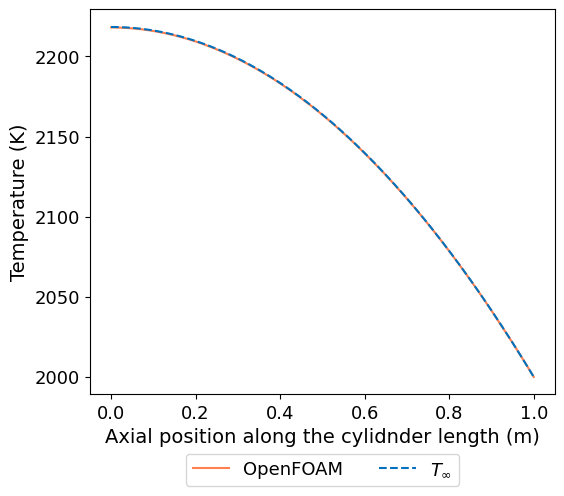

In [3]:
OpenFOAM=pd.read_csv("data/OpenFOAM_Tprofile.csv")     

fig, (ax1) = plt.subplots(1, figsize=(6,5))
ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1,1000), T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2, '--',label = '$T_\infty$', color='#0072bd', linewidth=1.5)

ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Axial position along the cylidnder length (m)',fontsize=14)
ax1.set_ylabel('Temperature (K)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#errore_end= (np.abs((OpenFOAM[-1,1]- (T_BC + GAMMA_T * (1 - np.linspace(0, 1,1000)**2) / 2)))/(OpenFOAM[-1,1]))*100
#print(rf'Relative error (@ final time): {errore_end:.5f}%')
print(OpenFOAM.shape)

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [13]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


#### DEFINE FINITE ELEMENT ESSENTIALS

In [16]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

#### IMPLEMENT FULLY IMPLICID FORWARD EULER FOR THE CONCENTRATION ONLY

In [7]:
# Initialise temperature and concentration solution containing the deviation from the initial condition:
sol_new_C = np.zeros((sFO_Px, N_ITER+1)) 
average_C = np.zeros(N_ITER)  

# Integrate using forward Euler up to the final time:
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    print('Current time:', cur_time, 's')
    average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
    print('Average concentration:', inte_C @ sol_new_C[mask_in_C, ii], 'atm/m^3\n')
    

    # Assemble current left-hand-side and right-hand-side
    cur_lhs = mass_C + TIME_DELTA * stiff_C
    cur_rhs = mass_C.dot(sol_new_C[mask_in_C, ii:ii+1]) + TIME_DELTA * (SOURCE_C * forc_C)

    # Compute perturbation from the initial temperature and concentration in the interior of the domain:
    sol_new_C[mask_in_C, ii+1], _ = linalg.bicgstab(cur_lhs, cur_rhs)

# Print final time and final average temperature and concentration:
print('Final time:', N_ITER * TIME_DELTA, 's')
average_C[ii] = inte_C @ sol_new_C[mask_in_C, ii]
print('Average concentration:', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 6.078242602748e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 1.1626509805161385e+23 atm/m^3

Current time: 30000.0 s
Average concentration: 1.679051935981452e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 2.1643452310935836e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 2.623122405376916e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 3.058609779351476e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 3.473237437190818e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 3.8689254838234056e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 4.2472386460567806e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 4.6094902084258795e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 4.956804204890086e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 5.290151984841684e+23 atm/m^3

Cur

In [8]:
np.savetxt('data/Fullorder_Cfield.csv', sol_new_C[:, :], delimiter=',', fmt='%d') #Salvo il campo di concentrazione ad ogni istante di tempo
np.savetxt('data/Fullorder_Caverage.csv', average_C[:], delimiter=',', fmt='%d')          #Salvo la concentrazione media ad ogni istante di tempo

In [2]:
sol_new_C = np.loadtxt('data/Fullorder_Cfield.csv', delimiter=',')
field = sol_new_C[:, -1] / volume

field = np.hstack((field, field))
coord_x = np.hstack((coordinates_Px[:, 0], - coordinates_Px[:, 0]))
coord_y = np.hstack((coordinates_Px[:, 1],   coordinates_Px[:, 1]))

#Per farlo metà
#field = sol_new_C[:, -1] / volume
#coord_x = np.hstack((coordinates_Px[:, 0]))
#coord_y = np.hstack((coordinates_Px[:, 1]))

max_tick = np.max(field)
tick_step = 0.2e25
print(max_tick)
ticks = np.linspace(0, max_tick, int(max_tick / tick_step) + 1)

plt.figure(figsize=(8, 6))
contour = plt.tricontourf(coord_x, coord_y, field, 400, cmap='RdBu_r', vmin=0, vmax = max_tick)
cbar = plt.colorbar(contour, ticks=ticks)       # Usa '%.2f' per due cifre decimali
cbar.ax.tick_params(labelsize=13)  # Dimensione del testo della colorbar
cbar.set_label('Concentration  (atm/m$^3$)', fontsize=14)
 
    
#plt.ylim((1-2e-2, 1))  #zoom sulla zona ad alto gradiente
plt.tick_params(axis="y", labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.xlabel('Radius  (m)',fontsize=14)
plt.ylabel('Length  (m)',fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('plot/FOM_xz.pdf', bbox_inches='tight')

NameError: name 'volume' is not defined

OpenFOAM average concentration (@ final time): 1.660453e+24 atm/m^3
Python average concentration (@ final time): 1.6440810801954723e+24 atm/m^3
Relative error (@ final time): 0.98599%
Relative error (@ final time) with model 3D: 0.64131%


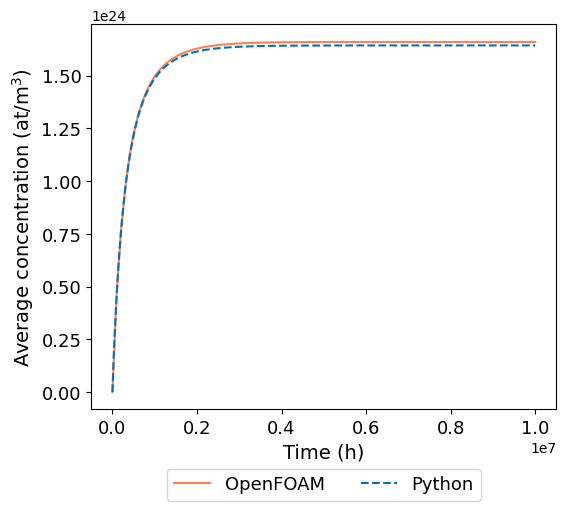

In [10]:
OpenFOAM=np.loadtxt("data/OpenFOAM_Caverage.dat")    
print('OpenFOAM average concentration (@ final time):', OpenFOAM[-1,1], 'atm/m^3')

model_3d = pd.read_csv("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/offline-online stages/model_3d/Turnbull/0. full order/sensitivity/10Layers_5Refine_0.75Transition_4Center.csv")

time = np.linspace(0, 1e7, sol_new_C.shape[1])
cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

fig, (ax1) = plt.subplots(1,  figsize=[6,5])
ax1.plot(OpenFOAM[:,0],OpenFOAM[:,1], color='#FF7F50', label='OpenFOAM', linewidth=1.5)
ax1.plot(time, inte_C @ sol_new_C[mask_in_C, :], '--',color='#0072bd', label='Python', linewidth=1.5)
#ax1.plot(model_3d['Time (s)'], model_3d['Average dC (atm/m^3)'], color='#050402', label='Python', linewidth=1.5)
ax1.set_xlabel('Time (h)', fontsize=14)
ax1.set_ylabel('Average concentration (at/m$^3$)',fontsize=14)
ax1.tick_params(axis="x", labelsize=13)
ax1.tick_params(axis="y", labelsize=13)

ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

print('Python average concentration (@ final time):', inte_C @ sol_new_C[mask_in_C, -1], 'atm/m^3')
errore_end= (np.abs((OpenFOAM[-1,1]-inte_C @ sol_new_C[mask_in_C, -1]))/(OpenFOAM[-1,1]))*100
print(rf'Relative error (@ final time): {errore_end:.5f}%')

errore_end= (np.abs((model_3d['Average dC (atm/m^3)'].iloc[-1]-inte_C @ sol_new_C[mask_in_C, -1]))/(model_3d['Average dC (atm/m^3)'].iloc[-1]))*100
print(rf'Relative error (@ final time) with model 3D: {errore_end:.5f}%')

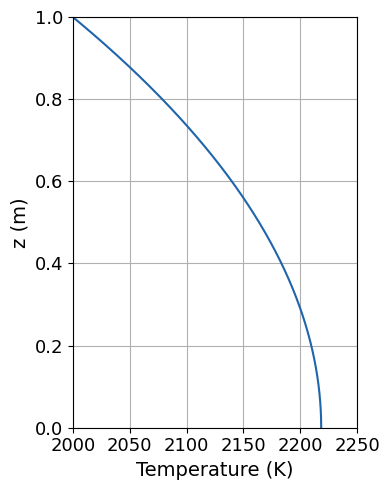

In [9]:
# Lettura dei parametri di riferimento dal file JSON
with open("data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
LENGTH = parameters["LENGTH"]               
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

#OpenFOAM=pd.read_csv("data/Temperature_along_z.csv")     

cmap = plt.get_cmap('RdBu')
color = cmap(0.9)

total_layers = list(set(coordinates_Px[:,1]))
all_layers = sorted(list(set(coordinates_Px[:, 1])))
effective_layers = np.linspace(all_layers[0], all_layers[-1], 5)  # Livelli da etichettare


fig, (ax1) = plt.subplots(1, figsize=(4,5))
#ax1.plot(OpenFOAM.iloc[:, -1], OpenFOAM.iloc[:, 0], label = 'OpenFOAM', color='#FF7F50', linewidth=1.5)
ax1.plot( T_BC + GAMMA_T * (1 - np.linspace(0,1 ,1001)**2) / 2, np.linspace(0,1,1001), label = '$T_\infty$', color=color, linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
#ax1.set_yticks(all_layers)  # Mostra tutti i tick
#ax1.set_yticklabels(
#    [f"{layer:.2f}" if layer in effective_layers else "" for layer in all_layers],
#    fontsize=13
#)  # Etichetta solo i livelli scelti, lasciando vuoti gli altri

ax1.set_ylim([0, 1])
ax1.set_xlim([2000, 2250])
ax1.set_ylabel('z (m)',fontsize=14)
ax1.set_xlabel('Temperature (K)',fontsize=14)
ax1.grid()
plt.tight_layout()
plt.savefig('plot/Temperature profile.pdf', bbox_inches='tight') 

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=2, fontsize=13)

#error = ((np.abs((OpenFOAM.iloc[:, 0]-(T_BC + GAMMA_T * (1 - np.linspace(0, 1,1001)**2) / 2))))/OpenFOAM.iloc[:, 0])*100
#print(np.max(error))

## **REDUCED BASIS MODEL CONSTRUCTION**

In [10]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import os
import sys
import json
import pandas as pd

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2642/353033749.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2642/353033749.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


#### DEFINE PARAMETERS TRAINING SET

In [ ]:
# Define size of the training parameter set:
sTR = 10000
FISSION_ENERGY = 3.215E-11

# Define parameters ranges:
MIN_FR, MAX_FR = 0, 5.00E+19        
MIN_K, MAX_K =  0.9, 8    
MIN_FY, MAX_FY = 0.00, 0.3
MIN_LL, MAX_LL = 0.25E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_BC, MAX_BC = 0, 2.5E+03                                                            


# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

# Extract z coordinates from the list of all Pq points coordinates and map those coordinates to the Pq points:
ZZ = np.sort(list(set(coordinates_Pq[:, 1])))
ZZ_1Dto2D = sparse.csr_matrix(np.array([coordinates_Pq[:, 1] == ZZ[kk] for kk in range(len(ZZ))]).T) * 1

# Compute a training set of concentration diffusion coefficients evaluated at the z coordinates: 
TRAINING = np.empty((len(ZZ), sTR))
for ii in range(sTR):
    TRAINING[:, ii] = ALPHA_C(ZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

#### CONSTRUCT AN AFFINE DECOMPOSITION FOR THE CONCENTRATION DIFFUSION COEFFICIENTS

In [24]:
# Compress the training set using singular value decomposition:
UU, SS, VV = np.linalg.svd(TRAINING @ TRAINING.T, full_matrices=False)
NN = np.sum(np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))]) > 1e-6) + 1

# Construct 1D and 3D basis for the concentration diffusion coefficient:
BASIS_D_1D = UU[:, :NN]
BASIS_D_2D = ZZ_1Dto2D @ BASIS_D_1D

# Use a greedy algorithm to identify the points (indeces) to interpolate the exact concentration coefficients:
INT_COO = [np.argmax(np.abs(BASIS_D_1D[:, 0]))]
for ii in range(1, NN):
    INT_COO.append(np.argmax(np.abs(BASIS_D_1D[:, ii] - BASIS_D_1D[:, :ii] @ np.linalg.solve(BASIS_D_1D[INT_COO, :ii],  BASIS_D_1D[INT_COO, ii]))))

# Extrat the z coordinates associated with the selected indeces:
INT_COO = np.array(INT_COO)
INT_CZZ = np.array([ZZ[INT_COO[ii]] for ii in range(NN)])

# Define interpolation operator mapping from the diffusion coefficient evaluated in the interpolation points to the linear combination coefficients:
mapDAtoCO = np.linalg.solve(BASIS_D_1D[INT_COO, :], np.eye(NN))

# Estimate the absolute and relative errors committed with this interpolation approach:
ABS_ERR = np.linalg.norm(TRAINING - BASIS_D_1D @ mapDAtoCO @ TRAINING[INT_COO, :], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(TRAINING, axis=0)

# Print maximum error:
print(np.max(REL_ERR))
print(VV.shape)
print(rf'Number of DEIM modes = {NN}')

0.0005118986578053517
(1000, 1000)
Number of DEIM modes = 8


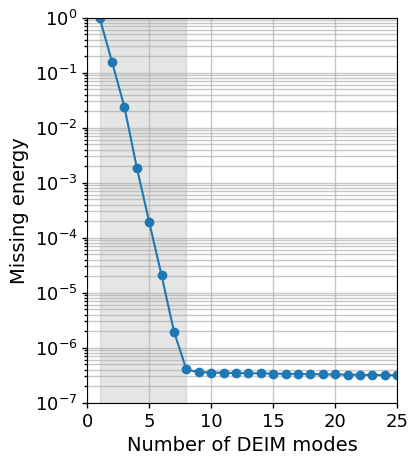

In [25]:
#guardiamo la missing energy del termine non-affine -> queste basi ridotte dopo le usiamo per davvero
cmap = plt.get_cmap('RdBu')
color = cmap(0.9)
 
missing = np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))])
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(range(1,26), missing[:25], '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of DEIM modes',fontsize=14)
ax1.set_ylabel('Missing energy',fontsize=14)
ax1.axvspan(1, NN, color='gray', alpha=0.2)
ax1.set_xlim([0,25])
ax1.set_ylim([1e-7, 1])
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig('plot/Missing energy.pdf', bbox_inches='tight')

#### ASSEMBLE AFFINELY DECOMPOSED STIFFNESS MATRICES AND COMPUTE THEIR COERCIVITY CONSTANTS

In [16]:
# Define two mass matrices respectively linked to the regularity of the solution and of its time derivative:
Y_mass = stiff_C
X_mass = mass_C

# Initialise array for the partial stiffness matrices and for their coercivity constants:
list_basis_stiff_C = np.array([sparse.csr_matrix((mass_C.shape)) for ii in range(2*NN)])
list_coerc_stiff_C = np.zeros((2*NN))

# Iterate over the selected basis for the diffusion coefficient field
for ii in range(NN):

    # Assemble the radial and axial partial stiffness matrices associated with the basis of the diffusivity:
    list_basis_stiff_C[00+ii] = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(BASIS_D_2D[:, ii:ii+1] * polar_weights_Pq[:, None]))
    list_basis_stiff_C[NN+ii] = PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(BASIS_D_2D[:, ii:ii+1] * polar_weights_Pq[:, None]))

    # Compute the sign of the axial and radial partial stiffness matrices:
    tsign_dz_C = np.sign(list_basis_stiff_C[NN + ii].trace())
    tsign_dr_C = np.sign(list_basis_stiff_C[00 + ii].trace())

    # Compute the coercivity constant of the axial and radial partial stiffness matrices:
    list_coerc_stiff_C[NN+ii] = tsign_dz_C / linalg.eigsh(Y_mass, k=1, M=tsign_dz_C * list_basis_stiff_C[NN+ii], which='LM', return_eigenvectors=False)[0]
    list_coerc_stiff_C[00+ii] = tsign_dr_C / linalg.eigsh(Y_mass, k=1, M=tsign_dr_C * list_basis_stiff_C[00+ii], which='LM', return_eigenvectors=False)[0]

#### COMPUTE THE INTERPOLATION COEFFICIENTS AND THE COERCIVITY COEFFICIENTS FOR ALL THE PARAMETERS

In [17]:
# Compute hte interpolation coefficients and the coercivity coefficients for the parameters in the training set:
list_inter_coef = np.empty((sTR, 2*NN))
list_coerc_coef = np.empty((sTR))

# Iterate over the training set:
for ii in range(sTR):
    cur_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

    # Compute the interpolation coefficients for the radial and axial partial stiffness matrices:
    list_inter_coef[ii, NN:] = cur_coef / LIST_LL[ii]**2
    list_inter_coef[ii, :NN] = cur_coef / LIST_RR[ii]**2

    # Compute a lower bound for the coercivity constants:
    list_coerc_coef[ii] = np.dot(list_coerc_stiff_C, list_inter_coef[ii, :])

# Compute interpolation and coercivity coeffientrs for the reference parameters:
cur_inter_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE)
cur_inter_coef = np.hstack((cur_inter_coef / RADIUS**2, cur_inter_coef / LENGTH**2))
cur_coerc_coef = np.dot(list_coerc_stiff_C, cur_inter_coef)

#### COMPUTE THE POD MODES OF THE REFERENCE SOLUTION

In [20]:
# Compute the singular value decomposition of the gramian matrix:
AA, GG, BB = np.linalg.svd(sol_new_C[mask_in_C, :].T @ Y_mass @ sol_new_C[mask_in_C, :], full_matrices=False)

# Compute total Y-energy of the training set:
Y_energy = np.sum([Y_mass.dot(sol_new_C[mask_in_C, ii]).dot(sol_new_C[mask_in_C, ii]) for ii in range(N_ITER+1)])

# Determine number of POD modes to retain:
sRB_C = np.sum([np.sqrt(np.sum(GG[ii:]) / Y_energy) > 1e-4 for ii in range(len(GG))])

# Assemble POD modes for the concentration field at the reference parameters:
BASIS_C_2D = sol_new_C[mask_in_C, :] @ AA[:, :sRB_C] @ np.diag(np.reciprocal(np.sqrt(GG[:sRB_C])))

print(rf'Number of POD modes = {sRB_C}')

Number of POD modes = 11


#### ASSEMBLE REDUCED MATRICES (LATER MUST BE CODED AS THE METHOD OF A CLASS)

In [21]:
# Project the Y- and X-mass matrices on the reduced basis space:
Y_mass_RB = BASIS_C_2D.T @ Y_mass @ BASIS_C_2D
X_mass_RB = BASIS_C_2D.T @ X_mass @ BASIS_C_2D

# Compute Rietz representer and projection of the forcing term:
forc_C_rietz_RB = linalg.spsolve(Y_mass, forc_C)
forc_C_proje_RB = BASIS_C_2D.T @ forc_C

# Compute Rietz representer and projection of the mass matrix tested versus the POD basis functions: 
mass_C_right_RB = mass_C @ BASIS_C_2D
mass_C_rietz_RB = linalg.spsolve(Y_mass, mass_C_right_RB)
mass_C_proje_RB = BASIS_C_2D.T @ mass_C_right_RB

# Compute the Rietz representer and projection of all the partial stiffness matrices from the affine decomposition:
list_basis_stiff_C_right_RB = np.array([list_basis_stiff_C[ii] @ BASIS_C_2D for ii in range(2*NN)])
list_basis_stiff_C_rietz_RB = np.array([linalg.spsolve(Y_mass, list_basis_stiff_C_right_RB[ii]) for ii in range(2*NN)])
list_basis_stiff_C_proje_RB = np.array([BASIS_C_2D.T @ list_basis_stiff_C_right_RB[ii] for ii in range(2*NN)])

# Pre-assemble the scalar and vector terms for the residual energy computation:
DD_pr_bb = (forc_C_rietz_RB.T @ forc_C) * (SOURCE_C * SOURCE_C)
DD_pr_bm = (forc_C_rietz_RB.T @ mass_C_right_RB) * (- 2 * SOURCE_C / TIME_DELTA)
DD_pr_mm = (mass_C_rietz_RB.T @ mass_C_right_RB) * (  1 / (TIME_DELTA * TIME_DELTA))

# Pre-assemble all the tensor terms for the residual energy computation:
DD_pr_ab = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ forc_C_rietz_RB for ii in range(2*NN)]) * (-2 * SOURCE_C)
DD_pr_am = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ mass_C_rietz_RB for ii in range(2*NN)]) * ( 2 / TIME_DELTA)
DD_pr_aa = np.array([[list_basis_stiff_C_right_RB[ii, :, :].T @ list_basis_stiff_C_rietz_RB[jj, :, :] for ii in range(2*NN)] for jj in range(2*NN)])

# Compute the weights for the integration of the reduced basis solutions:
weights_RB = np.ones((sFO_Px)) @ mass_Px[:, mask_in_C] @ BASIS_C_2D

#### COMPUTE REDUCED BASIS SOLUTION

In [22]:
# Assemble current reduced basis stiffness matrix:
stiff_C_proje_RB = np.tensordot(cur_inter_coef, list_basis_stiff_C_proje_RB, axes=[0, 0])
stiff_C_exact_RB = BASIS_C_2D.T @ stiff_C @ BASIS_C_2D

# Assemble current stiffness cross term for the computation of the residual energy:
cur_DD_pr_ab = np.tensordot(cur_inter_coef, DD_pr_ab, axes=[0, 0])
cur_DD_pr_am = np.tensordot(cur_inter_coef, DD_pr_am, axes=[0, 0])
cur_DD_pr_aa = np.tensordot(cur_inter_coef, np.tensordot(cur_inter_coef, DD_pr_aa, axes=[0, 0]), axes=[0, 0])

# Initialise reduced basis concentration solution:
sol_new_C_RB = np.zeros((sRB_C, N_ITER+1))
sol_new_C_FO = np.zeros((len(mask_in_C), N_ITER+1))

# Initialise errors and errors estimators:
energy_residual = np.empty((N_ITER))
energy_solution = np.empty((N_ITER))
energy_toterror = np.empty((N_ITER))

#
inte_C_RB = inte_C @ BASIS_C_2D

# Integrate using forward Euler up to the final time:
verbose = True
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    if verbose:
        print('Current time:', cur_time, 's')
        print('Average concentration:', inte_C_RB @ sol_new_C_RB[:, ii], 'atm/m^3\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs_RB = mass_C_proje_RB + TIME_DELTA * stiff_C_proje_RB
    cur_rhs_RB = mass_C_proje_RB.dot(sol_new_C_RB[:, ii:ii+1]) + TIME_DELTA * SOURCE_C * forc_C_proje_RB

    # Compute concentration in the interior of the domain:
    sol_new_C_RB[:, ii+1] = np.linalg.solve(cur_lhs_RB, cur_rhs_RB)[:, 0]
    sol_new_C_FO[:, ii+1] = BASIS_C_2D @ sol_new_C_RB[:, ii+1]
    
    # Compute partial errors and error bounds:
    energy_toterror[ii] = TIME_DELTA * stiff_C.dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1]).dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1])
    energy_solution[ii] = TIME_DELTA * stiff_C_proje_RB.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1])
    energy_residual[ii] = TIME_DELTA * (DD_pr_bb[0] + DD_pr_bm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        DD_pr_mm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        cur_DD_pr_ab.dot(sol_new_C_RB[:, ii+1]) + cur_DD_pr_aa.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1]) +\
                                        cur_DD_pr_am.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1]))

# Print current iteration and average temperature and concentration:
if verbose: 
    print('Final time:', N_ITER * TIME_DELTA, 's')
    print('Average concentration:', inte_C_RB @ sol_new_C_RB[:, -1], 'atm/m^3\n\n')

# Add final term energies:
energy_solution[-1] += mass_C_proje_RB.dot(sol_new_C_RB[:, -1]).dot(sol_new_C_RB[:, -1])
energy_toterror[-1] += mass_C.dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1]).dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1])

# Print errors and error bounds:
print('Error bound:', np.sqrt(np.sum(energy_residual) / np.sum(energy_solution) / cur_coerc_coef) )
print('Error exact:', np.sqrt(np.sum(energy_toterror) / np.sum(energy_solution)) )

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 6.078107813534615e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 1.1626833954188186e+23 atm/m^3

Current time: 30000.0 s
Average concentration: 1.6790467381583972e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 2.1643279754480688e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 2.6231139979366178e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 3.058613259984311e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 3.4732481453638436e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 3.868936743199503e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 4.247247928566338e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 4.6094965653549106e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 4.9568063394206685e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 5.290153212910751e+23 atm/m^3

#### SAVE ESSENTIAL FILES

In [23]:
# Save essentail files:
np.save('model_files/FF_FO.npy', forc_C)
np.save('model_files/XX_FO.npy', np.array([mass_C]))
np.save('model_files/YY_FO.npy', np.array([stiff_C]))
np.save('model_files/KK_FO.npy', list_basis_stiff_C)
np.save('model_files/CC_FO.npy', list_coerc_stiff_C)
np.save('model_files/ZZ_FO.npy', INT_CZZ)
np.save('model_files/II_FO.npy', mapDAtoCO)
np.save('model_files/AA_FO.npy', inte_C)

In [24]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
import sys

# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1251/4091097067.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1251/4091097067.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [ ]:
# Define size of the training parameter set:
sTR = 10000

FISSION_ENERGY = 3.215e-11
# Define parameters ranges:
MIN_FR, MAX_FR = 0, 5.00E+19        
MIN_K, MAX_K =  0.9, 8    
MIN_FY, MAX_FY = 0.00, 0.3
MIN_LL, MAX_LL = 0.25E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_BC, MAX_BC = 0, 2.5E+03         

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

# LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
# LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
# LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
# LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))

#### POD-GREEDY

In [28]:
# Define reference parameters:
cur_FY = 2.40E-01
cur_FR = 3.00E+19 
cur_BC = 2.00E+03
cur_LL = 1.00E-03
cur_RR = 1.00E-05
cur_K  = 2.208
cur_dt = 1.00E+04

# Define empty basis functions matrix and empty list of error bounds:
cur_basis = np.empty((FiniteElementCylinderSolver.sFO, 0))
cur_err_bounds = np.empty((sTR))

# Enter reduced basis space loop:
new_sRB = np.inf
while new_sRB > 0:

    # Assemble full order model and compute full order solution associated with the current parameter selection:
    solver_FO = FiniteElementCylinderSolver()
    solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K,dt=cur_dt)
    solution_FO = solver_FO.solve(n_steps=1000, verbose=False)

    # Compute orthogonal complement to the basis function and solution energy:
    orthogonal_FO = solution_FO - cur_basis @ np.linalg.solve(cur_basis.T @ solver_FO.XX_FO @ cur_basis, cur_basis.T @ solver_FO.XX_FO @ solution_FO)
    solution_energy_FO = np.einsum('ik,ik', solver_FO.XX_FO @ solution_FO, solution_FO)
    
    # Extract the POD basis from the full order solution:
    AA, GG, BB = np.linalg.svd(orthogonal_FO.T @ solver_FO.XX_FO @ orthogonal_FO, full_matrices=False)
    new_sRB = np.sum([np.sqrt(np.sum(GG[ii:]) / solution_energy_FO) > 1e-5 for ii in range(len(GG))])
    cur_basis = np.hstack((cur_basis, orthogonal_FO @ AA[:, :new_sRB] @ np.diag(np.reciprocal(np.sqrt(GG[:new_sRB])))))

    # Assemble reduced basis model:
    solver_RB = ReducedBasisCylinderSolver(cur_basis)
    for kk in range(sTR):
        solver_RB.assemble(F_YIELD=cur_FY, F_RATE=LIST_FR[kk], T_BC=LIST_BC[kk], LENGTH=LIST_LL[kk], RADIUS=LIST_RR[kk], KTH=LIST_K[kk], dt=cur_dt)

        # Compute current reduced basis solution and error bound:
        solution_RB, cur_err_bounds[kk] = solver_RB.solve(n_steps=1000, error_bound=True)

    # Identify new parameters where to evaluate the full order model:
    #cur_FY = cur_FY
    cur_FY = LIST_FY[np.argmax(cur_err_bounds)]
    cur_FR = LIST_FR[np.argmax(cur_err_bounds)]
    cur_BC = LIST_BC[np.argmax(cur_err_bounds)]
    cur_LL = LIST_LL[np.argmax(cur_err_bounds)]
    cur_RR = LIST_RR[np.argmax(cur_err_bounds)]
    cur_K = LIST_K[np.argmax(cur_err_bounds)]

    # Show worse reconstructed parameter configuration:
    print("The current reduced basis size is", cur_basis.shape[1])
    print("The selected Boundary Temperature is", cur_BC, "K")
    print("The selected Fission Rate is", cur_FR, "f/s")
    print("The selected Grain Length is", cur_LL, "m")
    print("The selected Grain Radius is", cur_RR, "m")
    print("The selected Fission Yield is", cur_FY, "at/fiss")
    print("The selected Fuel Thermal Conductivity is", cur_K, "W/(m K)\n")

The current reduced basis size is 17
The selected Boundary Temperature is 2207.4543710497805 K
The selected Fission Rate is 2.0220097495419976e+18 f/s
The selected Grain Length is 0.00025093821242568216 m
The selected Grain Radius is 1.2035000645515372e-05 m
The selected Fission Yield is 0.1347534572560396 at/fiss
The selected Fuel Thermal Conductivity is 1.3441969206059352 W/(m K)

The current reduced basis size is 25
The selected Boundary Temperature is 1868.8671611758696 K
The selected Fission Rate is 4.082506195342872e+19 f/s
The selected Grain Length is 0.0011327439569205908 m
The selected Grain Radius is 1.2235554643390956e-05 m
The selected Fission Yield is 0.06565882068797486 at/fiss
The selected Fuel Thermal Conductivity is 1.1778553608553062 W/(m K)

The current reduced basis size is 40
The selected Boundary Temperature is 2339.8177957295907 K
The selected Fission Rate is 1.061291969860434e+17 f/s
The selected Grain Length is 0.0012337545996327398 m
The selected Grain Radius 

KeyboardInterrupt: 

In [29]:
cur_err_bounds[np.argmax(cur_err_bounds)]

0.00439103377049212

In [30]:
import json
# Parametri con nomi diretti
data = {
    "N_AVOG": 6.022141E+23,
    "N_BOLT": 1.380649E-23,
    "FISSION_ENERGY": 3.215E-11,
    "T_BC": cur_BC,                                # Boundary Temperature [K]
    "FISSION_RATE": cur_FR,                        # Fission Rate [fiss/s]
    "LENGTH": cur_LL,                              # Grain Length [m]
    "RADIUS": cur_RR,                              # Grain Radius [m]
    "FISSION_YIELD": cur_FY,                       # Fission Yield [at/fiss]
    "FUEL_THERMAL_CONDUCTIVITY": cur_K             # Fuel Thermal Conductivity [W/(m K)]
}

# Scrittura su file JSON
with open("data/worst reconstructed parameters.json", "w") as json_file:
    json.dump(data, json_file, indent=4)


In [31]:
MM_RB = solver_RB.XX_RB    #matrice di massa. 2D
FF_RB = solver_RB.FF_RB    #funzionalità contro il vettore unitario. 1D
KK_RB = solver_RB.KK_RB    #basi della decomposizione affine della stiffness. 3D
AA_RB = solver_RB.AA_RB    #l'integratore per calcolare il valor medio sul volume data la soluzione ridotta, questo può essere sostituito dalla funzione che calcola il valor medio su diversi slice. 1D
ZZ_CO = solver_RB.ZZ_FO    #coordinate a cui dobbiamo valutare la temperatura. 1D
II_CO = solver_RB.II_FO    #coefficienti che mappano i valori del coefficiente di diffusione valutata sulle temperature nei coefficienti di combinazione lineare della decomposizione affine. 2D
basis = cur_basis 

In [32]:
# Salviamo tutte le matrici in un unico file HDF5
import h5py
with h5py.File('matrici_RB.h5', 'w') as hf:
    hf.create_dataset('MM_RB', data=MM_RB)
    hf.create_dataset('FF_RB', data=FF_RB)
    hf.create_dataset('KK_RB', data=KK_RB)
    hf.create_dataset('AA_RB', data=AA_RB)
    hf.create_dataset('ZZ_CO', data=ZZ_CO)
    hf.create_dataset('II_CO', data=II_CO)
    hf.create_dataset('basis', data=basis)

## **ONLINE**

In [33]:
# Pulizia
from IPython import get_ipython
get_ipython().magic('clear')
get_ipython().magic('reset -f')

# Import libraries:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
import sys
import json 
import h5py
import pandas as pd
import matplotlib.pyplot as plt

# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1251/3347887302.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('clear')
/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_1251/3347887302.py:4: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -f')


In [34]:
# Apri il file in modalità lettura
with h5py.File('matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]   #N_epsilon x N_epsilon
    FF_RB = hf['FF_RB'][:]   #N_epsilon x 1
    KK_RB = hf['KK_RB'][:]   #N_D+N_D x N_epsilon x N_epsilon
    AA_RB = hf['AA_RB'][:]   #N_epsilon
    ZZ_CO = hf['ZZ_CO'][:]   #N_D
    II_CO = hf['II_CO'][:]   #N_D x N_D

print(II_CO.shape)

(8, 8)


In [35]:
# Lettura dei parametri dal file JSON
with open("data/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
T_BC = parameters["T_BC"]  
FISSION_RATE = parameters["FISSION_RATE"]                   # [fiss/s]
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 # [at/fiss]
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]  # [W/(m K)]
TIME_FINAL = 1.00E+07
TIME_DELTA = 1.00E+04

FISSION_ENERGY = 3.215E-11                      #[J/fissions]
SOURCE_C = FISSION_RATE * FISSION_YIELD                      #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

TT = T_BC + GAMMA_T * (1 - ZZ_CO**2) / 2

WW = 7.60E-10 * np.exp(- 4.86E-19 / (TT * 1.380649E-23)) +\
     5.64E-25 * np.exp(- 1.91E-19 / (TT * 1.380649E-23)) * np.sqrt(FISSION_RATE) +\
     8.00E-40 * FISSION_RATE

CC_CO = np.hstack((II_CO @ WW / RADIUS**2, II_CO @ WW / LENGTH**2))

SS_RB = np.tensordot(CC_CO, KK_RB, axes=[0, 0])
QQ_RB = SOURCE_C * FF_RB

LHS_RB_static = MM_RB + TIME_DELTA * SS_RB
RHS_RB_static = TIME_DELTA * QQ_RB

In [36]:
old_sol_RB = np.zeros((MM_RB.shape[0], 1))
reconstructed_solution = np.zeros((1001))
for ii in range(1, 1001):
    old_sol_RB = np.linalg.solve(LHS_RB_static, RHS_RB_static + MM_RB.dot(old_sol_RB))
    value = np.dot(AA_RB, old_sol_RB)[0]
    reconstructed_solution[ii] = value
    print(reconstructed_solution[ii])


6.0782442382943265e+22
1.1626512604621452e+23
1.6790521126426554e+23
2.164345907355522e+23
2.6231234469903515e+23
3.0586115119879845e+23
3.4732405844254024e+23
3.868929012265028e+23
4.2472431821647396e+23
4.6094955298123485e+23
4.956808263576691e+23
5.2901567870511604e+23
5.610400413408476e+23
5.9183047575142094e+23
6.214558471895843e+23
6.499786018413257e+23
6.774557589218433e+23
7.039396933185116e+23
7.29478761512851e+23
7.541178083978325e+23
7.778985823491667e+23
8.008600787816025e+23
8.230388273654452e+23
8.444691344273622e+23
8.651832893816546e+23
8.852117420472886e+23
9.045832562085815e+23
9.233250436395948e+23
9.414628819398758e+23
9.590212188550727e+23
9.76023265231245e+23
9.924910783407119e+23
1.0084456369934843e+24
1.0239069095917265e+24
1.0388939160803983e+24
1.0534247845836015e+24
1.0675168033846067e+24
1.081186468801174e+24
1.0944495294213789e+24
1.1073210270946485e+24
1.1198153350149362e+24
1.1319461931852671e+24
1.1437267415134766e+24
1.1551695507560963e+24
1.16628665149

Errore in python: 1.351E-04%


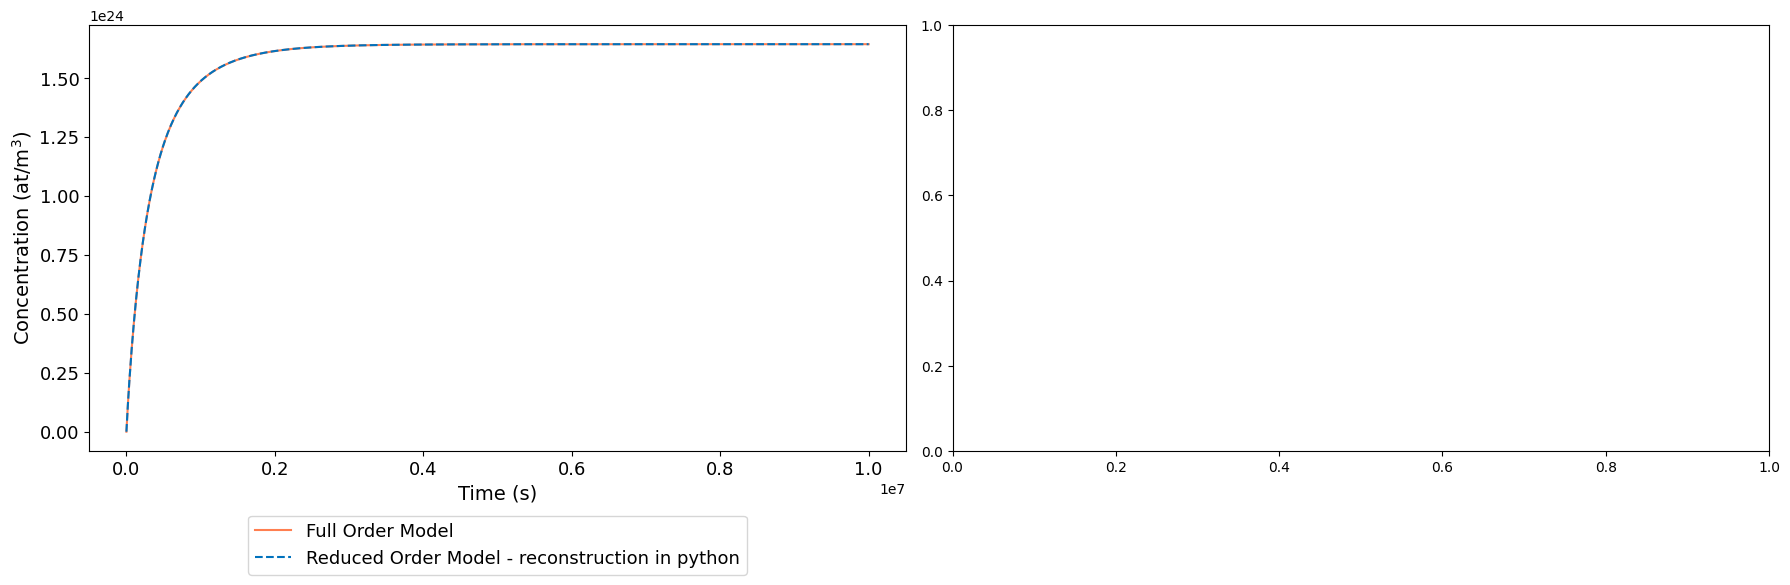

In [37]:
full_order = np.loadtxt('data/Fullorder_Caverage.csv', delimiter=',')
#sciantix =  pd.read_table("/Users/martina/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Git/rom-cylinder_DEIM-POD/trial/reference case/output.txt")

error = (np.abs(full_order[-1] - reconstructed_solution[-1])/full_order[-1])*100
print(f"Errore in python: {error:.3E}%")
#error = (np.abs(full_order['Average dC (atm/m^3)'].iloc[-1] - sciantix['Xe in grain (at/m3)'].iloc[-1])/full_order['Average dC (atm/m^3)'].iloc[-1])*100
#print(f"Errore in sciantix: {error:.3E}%")

# error_python = (np.abs(full_order.iloc[:, 1] - reconstructed_solution) / full_order.iloc[:, 1])*100
# error_python_max = np.max(error_python)
# print(f"Errore massimo in python: {error_python_max:.3E}%")

# error_sciantix = (np.abs(full_order.iloc[:, 1] - sciantix['Xe in grain (at/m3)']) / full_order.iloc[:, 1]) * 100
# error_sciantix_max = np.max(error_sciantix)
# print(f"Errore massimo in sciantix: {error_sciantix_max:.3E}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))
ax1.plot(np.linspace(0, 1e7, len(full_order)), full_order, label = 'Full Order Model', color='#FF7F50', linewidth=1.5)
ax1.plot(np.linspace(0, 1e7, 1001),reconstructed_solution , '--',label = 'Reduced Order Model - reconstruction in python', color='#0072bd', linewidth=1.5)
#ax1.plot(np.linspace(0, 1e7, 1001),sciantix['Xe in grain (at/m3)'], '--', label='Reduced Order Model - reconstruction in sciantix', color='#050402', linewidth=1.5)
ax1.tick_params(axis="y", labelsize=13)
ax1.tick_params(axis='x', labelsize=13)
ax1.ticklabel_format(useOffset=False)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel('Concentration (at/m$^3$)',fontsize=14)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=1, fontsize=13)

# ax2.plot(np.linspace(0, 1e7, 1001), error_python, color='#FF7F50', linewidth=1.5)
# ax2.tick_params(axis="y", labelsize=13)
# ax2.tick_params(axis='x', labelsize=13)
# ax2.ticklabel_format(useOffset=False)
# ax2.set_xlabel('Time (s)',fontsize=14)
# ax2.set_ylabel('Error in python %',fontsize=14)


plt.tight_layout()